<a href="https://colab.research.google.com/github/riazul99/CSE428_Project_Tomato_leaf_disease_detection/blob/main/428_v2_0_leaf_septoria.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import keras
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

import numpy as np
import pandas as pd

# Use os to get the data from Google Drive
import os
import matplotlib.pyplot as plt
keras.__version__

'2.8.0'

In [2]:
from google.colab import files
files.upload()  

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mdriazul","key":"5bb17a58066ca2db07beb0759d06b841"}'}

In [3]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

rm: cannot remove '/root/.kaggle': No such file or directory


In [12]:
!kaggle datasets download -d kaustubhb999/tomatoleaf --unzip

 98% 176M/179M [00:01<00:00, 151MB/s]
100% 179M/179M [00:01<00:00, 173MB/s]


In [18]:
print(len(os.listdir('/content/tomato/train/Tomato___Septoria_leaf_spot')))
print(len(os.listdir('/content/tomato/train/Tomato___healthy')))

1000
1000


In [19]:
print(len(os.listdir('/content/tomato/val/Tomato___Septoria_leaf_spot')))
print(len(os.listdir('/content/tomato/val/Tomato___healthy')))

100
100


In [20]:
# After loading the drive, copy the path of your train & validation data
train_path = '/content/tomato/train'
val_path = '/content/tomato/val'

In [21]:
# Custom function to plot the image
# plot the image
def imshow(img_arr):
    # We want to display multiple images in a single row,
    # Thus, we use subplots
    fig, axes = plt.subplots(1, 5, figsize=(10,10))

    axes = axes.flatten()

    for img, ax in zip(img_arr, axes):
        ax.imshow(img)
        
    plt.show()

In [28]:
# Augmentation of the images 
# using keras.ImageDataGenerator

train_aug = ImageDataGenerator(
    rescale = 1/255,   # Divide the pixel values by 255 to narmalize them
    rotation_range = 30,          # Rotate
    width_shift_range = 0.1,      # shift through the width
    height_shift_range = 0.1,     # shift through the height
    shear_range = 0.1,            # apply shear on the image
    horizontal_flip = True,       # Flip horizontally
    vertical_flip = True,         # Flip vertically
    fill_mode = 'nearest',        # To fill up the pixels cut off during augmentation
    brightness_range = [0.7,1.4]  # To introduce different lighting conditions
)

train_data = train_aug.flow_from_directory(train_path, 
                                           target_size = (150,150),   #Reduce shape of images to 150 X 150
                                           batch_size=32,             # Take 32 images at once and do it on them
                                           class_mode = 'binary')

Found 2000 images belonging to 2 classes.


In [29]:
# We repeat the above process for the validation set also
# But bacause it is the validation set, we apply less augmentation
# Do less augmentation for validation data
valid_aug = ImageDataGenerator(rescale = 1/255, rotation_range = 40)

# We used rotation to add just 
# a little more augmentation 
# to get more images for our validation set

valid_data = valid_aug.flow_from_directory(val_path,
                                           target_size = (150,150),
                                           batch_size = 32,
                                           class_mode = 'binary'
                                           )

Found 200 images belonging to 2 classes.


In [30]:
print(train_data.class_indices)
print(valid_data.class_indices)

{'Tomato___Septoria_leaf_spot': 0, 'Tomato___healthy': 1}
{'Tomato___Septoria_leaf_spot': 0, 'Tomato___healthy': 1}


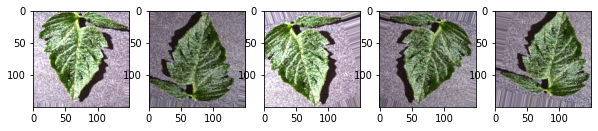

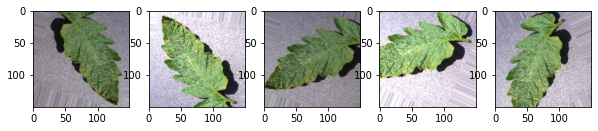

In [31]:
imshow(train_data[0][0][0] for i in range(5))
imshow(train_data[0][0][5] for i in range(5))

In [32]:
# Just to check if the dataset is balanced or not
y = train_data.classes
count_septoria, count_healthy = 0,0

for x in y:
    if x==0:
        count_healthy += 1
    else:
        count_septoria += 1
print("Septoria:",count_septoria,"   Healthy:",count_healthy)

Septoria: 1000    Healthy: 1000


Buildding CNN Model

In [33]:
cnn = keras.models.Sequential()
# 3 Convolution and 3 Max Pool layers
cnn.add(layers.Conv2D( filters=32, kernel_size=(4,4), activation='relu', input_shape = [150,150,3] ))
cnn.add(layers.MaxPooling2D( pool_size=(2,2)))

cnn.add(layers.Conv2D( filters=64, kernel_size=(4,4), activation='relu' ))
cnn.add(layers.MaxPooling2D( pool_size = (2,2) ))

cnn.add(layers.Conv2D( filters=128, kernel_size=(4,4), activation='relu' ))
cnn.add(layers.MaxPooling2D( pool_size = (2,2) ))

# Dense Layer with Dropout
cnn.add(layers.Dropout(0.4))
cnn.add(layers.Flatten())
cnn.add(layers.Dense(units=128, activation = 'relu'))

# Hidden Layer
cnn.add(layers.Dropout(0.15))
cnn.add(layers.Dense(units=256, activation = 'relu'))

# Output layer
cnn.add(layers.Dropout(0.25))
cnn.add(layers.Dense(units=1, activation = 'sigmoid'))

In [34]:
cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [35]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 147, 147, 32)      1568      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 73, 73, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 70, 70, 64)        32832     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 35, 35, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 128)       131200    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 128)      0

In [37]:
history = cnn.fit( train_data, epochs=50, verbose=1, validation_data=valid_data )

Epoch 1/50
63/63 [==============================] - 134s 2s/step - loss: 0.1762 - accuracy: 0.9320 - val_loss: 0.0708 - val_accuracy: 0.9700
Epoch 2/50
63/63 [==============================] - 133s 2s/step - loss: 0.1142 - accuracy: 0.9615 - val_loss: 0.1214 - val_accuracy: 0.9600
Epoch 3/50
63/63 [==============================] - 151s 2s/step - loss: 0.1390 - accuracy: 0.9490 - val_loss: 0.1134 - val_accuracy: 0.9600
Epoch 4/50
63/63 [==============================] - 133s 2s/step - loss: 0.0668 - accuracy: 0.9760 - val_loss: 0.0282 - val_accuracy: 0.9850
Epoch 5/50
63/63 [==============================] - 133s 2s/step - loss: 0.0703 - accuracy: 0.9725 - val_loss: 0.1083 - val_accuracy: 0.9700
Epoch 6/50
63/63 [==============================] - 132s 2s/step - loss: 0.0914 - accuracy: 0.9680 - val_loss: 0.0583 - val_accuracy: 0.9800
Epoch 7/50
63/63 [==============================] - 133s 2s/step - loss: 0.0509 - accuracy: 0.9830 - val_loss: 0.0165 - val_accuracy: 0.9950
Epoch 8/50
63

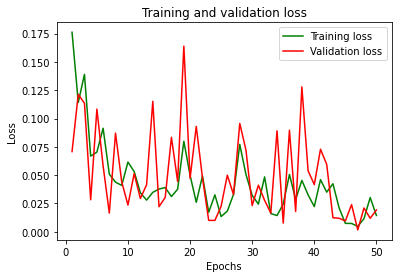

In [38]:
# Loss Curves
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

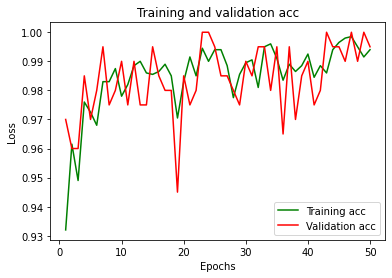

In [40]:
# Accuracy curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation acc')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()